In [1]:
# from __future__ import division
import env
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
import utilities as utils


%matplotlib inline

In [47]:
grocery_query = """
SELECT *
    FROM grocery_customers
"""

grocery_df = utils.generate_df("grocery.csv", grocery_query, \
                               utils.generate_db_url(env.user, env.password, env.host, "grocery_db"))

In [7]:
grocery_df.head()

,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,2,3,12669,9656,7561,214,2674,1338
1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,1,3,13265,1196,4221,6404,507,1788
4,4,2,3,22615,5410,7198,3915,1777,5185


In [8]:
grocery_df.set_index('customer_id', inplace=True)
grocery_df

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185
...,...,...,...,...,...,...,...,...
435,1,3,29703,12051,16027,13135,182,2204
436,1,3,39228,1431,764,4510,93,2346
437,2,3,14531,15488,30243,437,14841,1867


In [9]:
train, validate, test = utils.split_dataframe(grocery_df)

In [13]:
scale_cols = ['Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']

train_scaled, validate_scaled, test_scaled = utils.generate_scaled_splits(train[scale_cols], validate[scale_cols],\
                                                                          test[scale_cols])

In [15]:
train_scaled.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0.054548,0.131106,0.147987,0.005397,0.218706,0.058010
1,0.048236,0.044440,0.026188,0.012849,0.023517,0.031685
2,0.236488,0.023522,0.043247,0.174543,0.012297,0.037234
3,0.081813,0.338874,0.178162,0.000000,0.170276,0.008970
4,0.046577,0.016513,0.014109,0.029314,0.012469,0.009700


In [16]:
train_scaled.reset_index(inplace=True)

train_scaled.rename(columns={'index' : 'customer_id'}, inplace=True)

train_scaled.set_index('customer_id', inplace=True)

## Using DBSCAN

In [27]:
np_array = train_scaled.values.astype("float32", copy=False)

dbsc = DBSCAN(eps=.10, min_samples=20).fit(np_array)

In [32]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(train_scaled.columns)
scaled_columns = ["Scaled_" + column for column in columns]

train_scaled.columns = scaled_columns

train = pd.merge(train, train_scaled, on=train.index)

train.drop(columns=['key_0'], inplace=True)

In [38]:
train

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Milk,Scaled_Grocery,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen
0,2,1,3062,6154,13916,230,8933,2784,0.054548,0.131106,0.147987,0.005397,0.218706,0.058010
1,1,3,2708,2160,2642,502,965,1522,0.048236,0.044440,0.026188,0.012849,0.023517,0.031685
2,1,3,13265,1196,4221,6404,507,1788,0.236488,0.023522,0.043247,0.174543,0.012297,0.037234
3,2,3,4591,15729,16709,33,6956,433,0.081813,0.338874,0.178162,0.000000,0.170276,0.008970
4,1,3,2615,873,1524,1103,514,468,0.046577,0.016513,0.014109,0.029314,0.012469,0.009700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,1,3,8533,5506,5160,13486,1377,1498,0.152107,0.117045,0.053391,0.368565,0.033609,0.031185
242,2,3,10362,9232,11009,737,3537,2342,0.184722,0.197895,0.116581,0.019287,0.086522,0.048790
243,2,3,4048,5164,10391,130,813,179,0.072130,0.109624,0.109905,0.002657,0.019793,0.003671
244,2,3,15168,10556,12477,1920,6506,714,0.270422,0.226625,0.132441,0.051697,0.159252,0.014831


In [39]:
labels = dbsc.labels_
labels[0:10]

array([ 0,  0, -1, -1,  0,  0, -1,  0, -1,  0])

In [41]:
train['labels'] = labels
train.labels.value_counts()

 0    151
-1     95
Name: labels, dtype: int64

In [42]:
train[train.labels == -1].head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Scaled_Fresh,Scaled_Milk,Scaled_Grocery,Scaled_Frozen,Scaled_Detergents_Paper,Scaled_Delicassen,labels
2,1,3,13265,1196,4221,6404,507,1788,0.236488,0.023522,0.043247,0.174543,0.012297,0.037234,-1
3,2,3,4591,15729,16709,33,6956,433,0.081813,0.338874,0.178162,0.000000,0.170276,0.008970,-1
6,1,3,29729,4786,7326,6130,361,1083,0.530074,0.101421,0.076792,0.167037,0.008721,0.022528,-1
8,2,3,21465,7243,10685,880,2386,2749,0.382710,0.154736,0.113081,0.023205,0.058326,0.057280,-1
13,2,3,21217,6208,14982,3095,6707,602,0.378288,0.132277,0.159504,0.083888,0.164176,0.012495,-1


In [43]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(train.describe())
print("-------------")
print("Inliers")
print(train[train.labels==0].describe())
print("-------------")
print("Outliers")
print(train[train.labels==-1].describe())

Population
          Channel      Region         Fresh          Milk       Grocery  \
count  246.000000  246.000000    246.000000    246.000000    246.000000   
mean     1.321138    2.569106  11160.243902   5662.804878   7972.032520   
std      0.467866    0.767517  10938.987241   6565.928893  10387.188297   
min      1.000000    1.000000      3.000000    112.000000    218.000000   
25%      1.000000    2.000000   2927.500000   1515.750000   2149.000000   
50%      1.000000    3.000000   7811.000000   3684.500000   4829.000000   
75%      2.000000    3.000000  15599.000000   7079.500000  10284.500000   
max      2.000000    3.000000  56082.000000  46197.000000  92780.000000   

             Frozen  Detergents_Paper    Delicassen  Scaled_Fresh  \
count    246.000000        246.000000    246.000000    246.000000   
mean    2522.768293       2868.939024   1485.272358      0.198956   
std     3557.961083       5247.338332   3300.707690      0.195064   
min       33.000000          5.000000

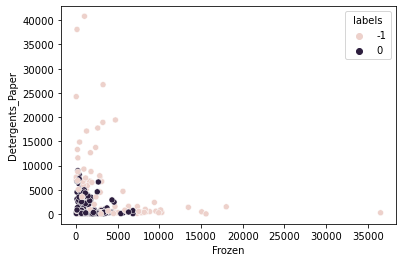

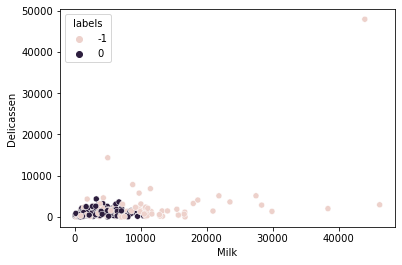

In [44]:
sns.scatterplot(train.Frozen, train.Detergents_Paper, hue=train.labels)
plt.show()

sns.scatterplot(train.Milk, train.Delicassen, hue=train.labels)
plt.show()

## 3D Modeling

In [51]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib qt

fig = plt.figure(1, figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

# plot the points
ax.scatter(train.Frozen, train.Detergents_Paper, train.Grocery,
           c=train.labels, edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

ax.set_xlabel('Frozen')
ax.set_ylabel('Detergents_Paper')
ax.set_zlabel('Grocery')

Text(0.5, 0, 'Grocery')

## Tuning EPS

https://towardsdatascience.com/how-to-use-dbscan-effectively-ed212c02e62

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
from sklearn.neighbors import NearestNeighbors

from kneed import KneeLocator

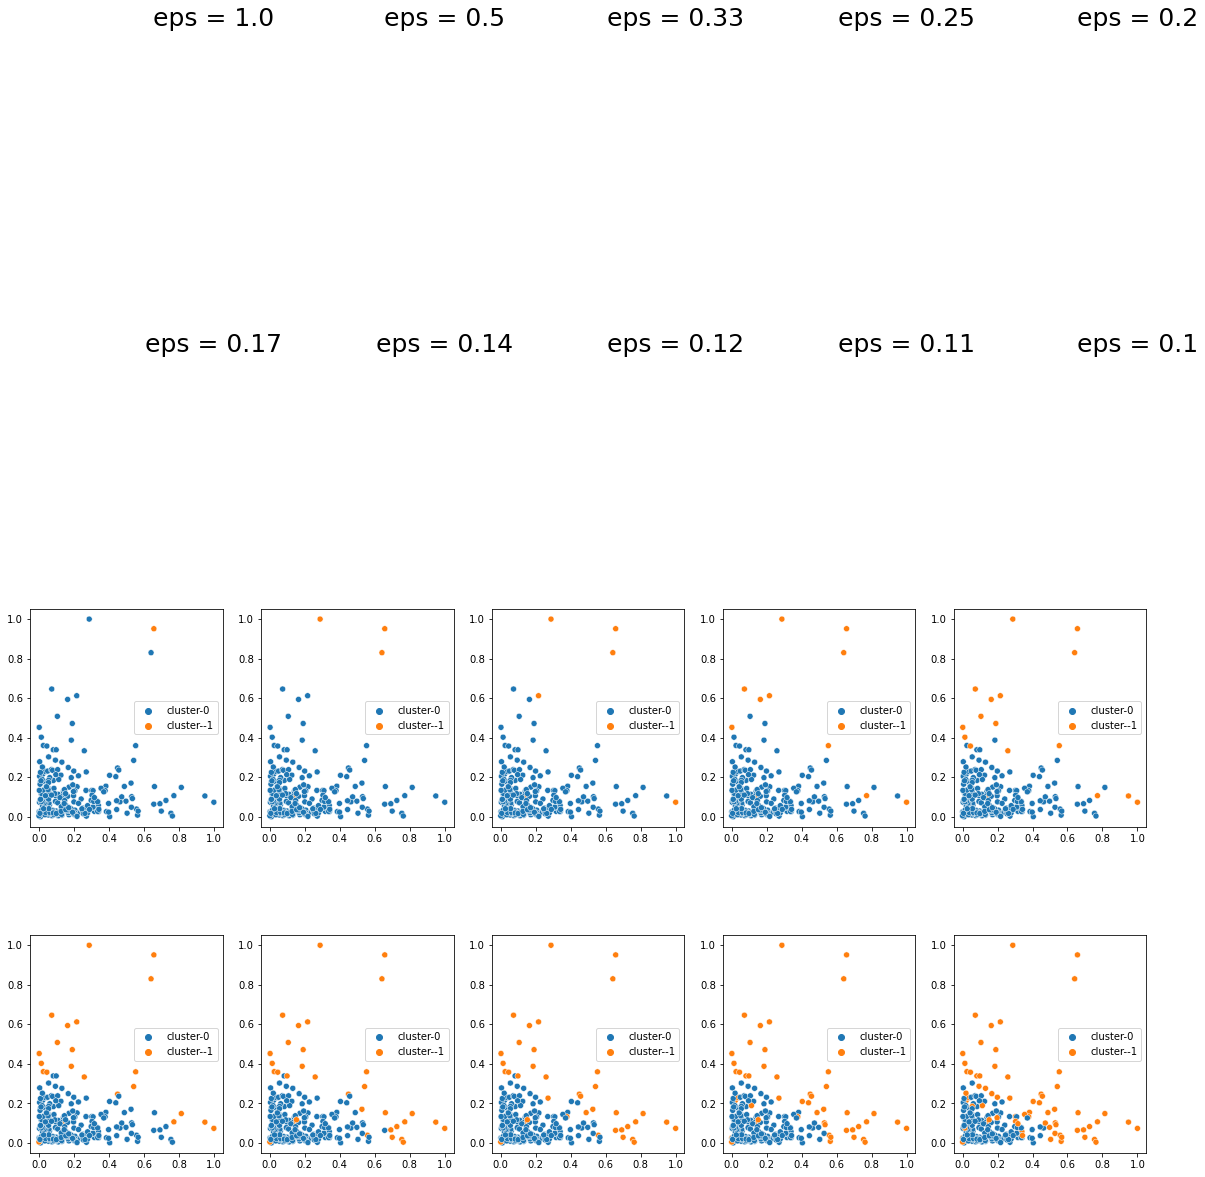

In [53]:
%matplotlib inline

fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1

for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=10).fit(np_array)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 2)), fontsize=25, ha="center")
    sns.scatterplot(np_array[:,0], np_array[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1

Text(0, 0.5, 'Distance')

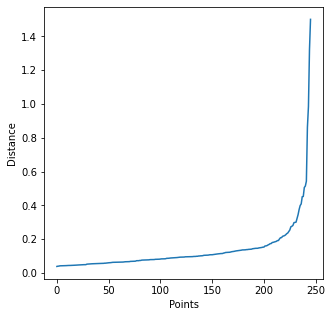

In [56]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(np_array)
distances, indices = neighbors.kneighbors(np_array)

distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

0.2172362222340953


<Figure size 360x360 with 0 Axes>

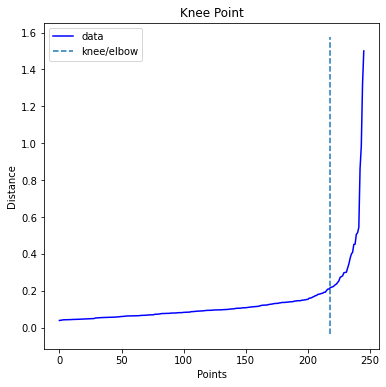

In [57]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

<AxesSubplot:>

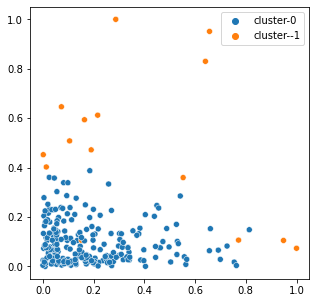

In [58]:
db = DBSCAN(eps=distances[knee.knee], min_samples=10).fit(np_array)
labels = db.labels_

fig = plt.figure(figsize=(5, 5))
sns.scatterplot(np_array[:,0], np_array[:,1], hue=["cluster-{}".format(x) for x in labels])

## Zillow

In [87]:
from wrangle_zillow import wrangle_zillow_data

In [99]:
train, validate, test = wrangle_zillow_data()

In [100]:
zillow_df = train

In [101]:
zillow_df.head()

,bathrooms,bedrooms,build_quality,fractional_bathrooms,sqft,fips,latitude,longitude,lot_size,land_use_code,...,Cooperative,"Duplex (2 Units, Any Combination)","Manufactured, Modular, Prefabricated Homes",Mobile Home,Planned Unit Development,"Quadruplex (4 Units, Any Combination)",Residential General,Single Family Residential,Townhouse,"Triplex (3 Units, Any Combination)"
62513,2.0,4.0,8.0,2.0,1960.0,6059.0,33536818.0,-117720002.0,8132.0,122,...,0,0,0,0,0,0,0,1,0,0
18292,2.0,3.0,7.0,2.0,1572.0,6037.0,33869300.0,-118372000.0,15001.0,010C,...,0,0,0,0,0,0,0,0,0,0
65565,2.5,2.0,8.0,2.5,1222.0,6059.0,33686058.0,-117672731.0,7205.0,34,...,0,0,0,0,0,0,0,0,0,0
7199,3.0,5.0,7.0,3.0,3326.0,6037.0,34270500.0,-118291094.0,9306.0,0100,...,0,0,0,0,0,0,0,1,0,0
3402,1.0,3.0,4.0,1.0,1186.0,6037.0,34191660.0,-118434380.0,7385.0,0100,...,0,0,0,0,0,0,0,1,0,0


In [102]:
scale_cols = ['fractional_bathrooms', 'bedrooms', 'sqft', 'build_quality', 'age']

train_scaled, validate_scaled, test_scaled = utils.generate_scaled_splits(train[scale_cols], validate[scale_cols],\
                                                                          test[scale_cols])

In [103]:
dbsc = DBSCAN(eps=.04, min_samples=500).fit(train_scaled)

In [104]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(train_scaled.columns)
scaled_columns = ["Scaled_" + column for column in columns]

train_scaled.columns = scaled_columns

train = pd.merge(train, train_scaled, on=train.index)

train.drop(columns=['key_0'], inplace=True)

In [105]:
train.head()

,bathrooms,bedrooms,build_quality,fractional_bathrooms,sqft,fips,latitude,longitude,lot_size,land_use_code,...,"Quadruplex (4 Units, Any Combination)",Residential General,Single Family Residential,Townhouse,"Triplex (3 Units, Any Combination)",Scaled_fractional_bathrooms,Scaled_bedrooms,Scaled_sqft,Scaled_build_quality,Scaled_age
0,2.0,4.0,8.0,2.0,1960.0,6059.0,33536818.0,-117720002.0,8132.0,122,...,0,0,1,0,0,0.222222,0.444444,0.389571,0.636364,0.318841
1,2.0,3.0,7.0,2.0,1572.0,6037.0,33869300.0,-118372000.0,15001.0,010C,...,0,0,0,0,0,0.222222,0.333333,0.305969,0.545455,0.275362
2,2.5,2.0,8.0,2.5,1222.0,6059.0,33686058.0,-117672731.0,7205.0,34,...,0,0,0,0,0,0.333333,0.222222,0.230554,0.636364,0.159420
3,3.0,5.0,7.0,3.0,3326.0,6037.0,34270500.0,-118291094.0,9306.0,0100,...,0,0,1,0,0,0.444444,0.555556,0.683904,0.545455,0.115942
4,1.0,3.0,4.0,1.0,1186.0,6037.0,34191660.0,-118434380.0,7385.0,0100,...,0,0,1,0,0,0.000000,0.333333,0.222797,0.272727,0.478261


In [106]:
labels = dbsc.labels_
labels[0:10]

array([-1, -1, -1, -1,  0,  2, -1,  1, -1, -1])

In [107]:
train['labels'] = labels
train.labels.value_counts()

-1    29258
 1     1630
 2     1147
 0     1000
 3      614
Name: labels, dtype: int64

In [108]:
train[train.labels == -1].head()

,bathrooms,bedrooms,build_quality,fractional_bathrooms,sqft,fips,latitude,longitude,lot_size,land_use_code,...,Residential General,Single Family Residential,Townhouse,"Triplex (3 Units, Any Combination)",Scaled_fractional_bathrooms,Scaled_bedrooms,Scaled_sqft,Scaled_build_quality,Scaled_age,labels
0,2.0,4.0,8.0,2.0,1960.0,6059.0,33536818.0,-117720002.0,8132.0,122,...,0,1,0,0,0.222222,0.444444,0.389571,0.636364,0.318841,-1
1,2.0,3.0,7.0,2.0,1572.0,6037.0,33869300.0,-118372000.0,15001.0,010C,...,0,0,0,0,0.222222,0.333333,0.305969,0.545455,0.275362,-1
2,2.5,2.0,8.0,2.5,1222.0,6059.0,33686058.0,-117672731.0,7205.0,34,...,0,0,0,0,0.333333,0.222222,0.230554,0.636364,0.159420,-1
3,3.0,5.0,7.0,3.0,3326.0,6037.0,34270500.0,-118291094.0,9306.0,0100,...,0,1,0,0,0.444444,0.555556,0.683904,0.545455,0.115942,-1
6,3.0,4.0,8.0,3.0,1964.0,6037.0,33852162.0,-118066129.0,6093.0,0101,...,0,1,0,0,0.444444,0.444444,0.390433,0.636364,0.333333,-1


In [109]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(train.describe())
print("-------------")
print("Inliers")
print(train[train.labels==0].describe())
print("-------------")
print("Outliers")
print(train[train.labels==-1].describe())

Population
          bathrooms      bedrooms  build_quality  fractional_bathrooms  \
count  33649.000000  33649.000000   33649.000000          33649.000000   
mean       2.196291      3.095991       6.941454              2.209100   
std        0.821414      1.035450       1.534675              0.802449   
min        0.000000      0.000000       1.000000              1.000000   
25%        2.000000      2.000000       6.000000              2.000000   
50%        2.000000      3.000000       8.000000              2.000000   
75%        3.000000      4.000000       8.000000              3.000000   
max        5.500000      9.000000      12.000000              5.500000   

               sqft          fips      latitude     longitude      lot_size  \
count  33649.000000  33649.000000  3.364900e+04  3.364900e+04  33649.000000   
mean    1704.768463   6050.486047  3.399376e+07 -1.181824e+08   7386.990282   
std      695.296744     21.574339  2.686282e+05  3.711016e+05   3519.984121   
min   

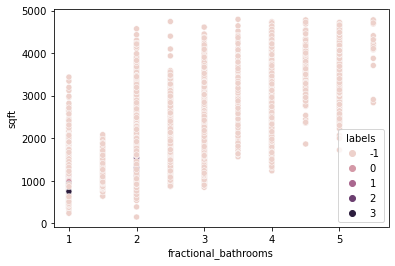

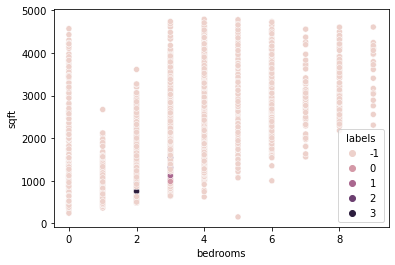

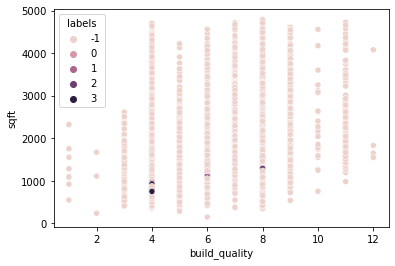

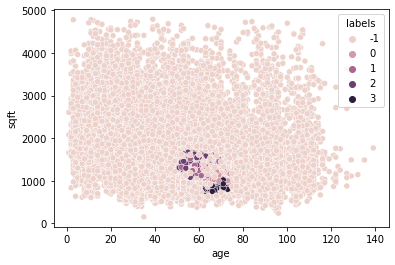

In [110]:
sns.scatterplot(train.fractional_bathrooms, train.sqft, hue=train.labels)
plt.show()

sns.scatterplot(train.bedrooms, train.sqft, hue=train.labels)
plt.show()

sns.scatterplot(train.build_quality, train.sqft, hue=train.labels)
plt.show()

sns.scatterplot(train.age, train.sqft, hue=train.labels)
plt.show()

## Codeup logs

In [285]:
log_df = pd.read_csv(env.data_path + "anonymized-curriculum-access.txt.gz", compression="gzip", header=None, sep=" ")

In [286]:
column_dict = {0 : 'date', 1 : 'time', 2 : 'url', 3 : 'user_id', 4 : 'cohort_id', 5 : 'ip_address'}

log_df = log_df.rename(columns=column_dict)

In [287]:
log_df['timestamp'] = log_df.date + " " + log_df.time
log_df = utils.set_index_to_datetime(log_df, 'timestamp')

## Assumptions
1. cohort_id = 1 are teaching assistants
1. cohort_id = 28 are instructors
1. cohort_id = nan are students that did not finish (dnf)
1. all data science cohort IDs are in the 100s
1. most students only have 1 cohort ID
1. only webdev students would access a page with "java" in the url
1. only data science students would access a page with "classification" in the url

In [288]:
log_df.cohort_id = log_df.cohort_id.fillna(value=777)

In [289]:
log_df['has_visited_java'] = log_df.url

In [290]:
log_df.has_visited_java = log_df.has_visited_java.astype(str)

In [291]:
log_df.has_visited_java = log_df.has_visited_java.apply(lambda url : 1 if url.find("java") > -1 else 0)

In [292]:
visited_java = log_df.groupby('user_id').has_visited_java.sum()

In [293]:
log_df = pd.merge(log_df, visited_java, on='user_id')

In [294]:
log_df.drop(columns=['has_visited_java_x'], inplace=True)

In [295]:
log_df.rename(columns={'has_visited_java_y' : 'has_visited_java'}, inplace=True)

In [296]:
log_df

,date,time,url,user_id,cohort_id,ip_address,has_visited_java
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,936
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,936
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,936
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,936
4,2018-01-26,10:40:15,javascript-i/functions,1,8.0,97.105.19.61,936
...,...,...,...,...,...,...,...
900218,2021-04-21,09:09:42,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1
900219,2021-04-21,09:29:08,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1
900220,2021-04-21,10:05:39,examples/css/bootstrap-grids.html,981,138.0,67.11.98.144,1
900221,2021-04-21,11:01:19,html-css,981,138.0,67.11.98.144,1


In [297]:
log_df['is_webdev'] = log_df.has_visited_java.apply(lambda java : 1 if java > 0 else 0)

In [298]:
log_df['has_visited_classification'] = log_df.url
log_df.has_visited_classification = log_df.has_visited_classification.astype(str)

log_df.has_visited_classification = log_df.has_visited_classification.apply(lambda u : 1 if \
                                                                            u.find("classification") > -1 else 0)

In [299]:
visited_classification = log_df.groupby('user_id').has_visited_classification.sum()

In [300]:
log_df = pd.merge(log_df, visited_classification, on='user_id')

In [301]:
log_df.drop(columns=['has_visited_classification_x'], inplace=True)
log_df.rename(columns={'has_visited_classification_y' : 'has_visited_classification'}, inplace=True)

In [302]:
log_df['is_data_sci'] = log_df.has_visited_classification.apply(lambda hvc : 1 if hvc > 0 else 0)

In [303]:
log_df

,date,time,url,user_id,cohort_id,ip_address,has_visited_java,is_webdev,has_visited_classification,is_data_sci
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,936,1,393,1
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,936,1,393,1
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,936,1,393,1
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,936,1,393,1
4,2018-01-26,10:40:15,javascript-i/functions,1,8.0,97.105.19.61,936,1,393,1
...,...,...,...,...,...,...,...,...,...,...
900218,2021-04-21,09:09:42,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1,1,0,0
900219,2021-04-21,09:29:08,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1,1,0,0
900220,2021-04-21,10:05:39,examples/css/bootstrap-grids.html,981,138.0,67.11.98.144,1,1,0,0
900221,2021-04-21,11:01:19,html-css,981,138.0,67.11.98.144,1,1,0,0


In [304]:
num_of_cohorts = log_df.groupby('user_id').cohort_id.nunique()

In [305]:
log_df = pd.merge(log_df, num_of_cohorts, on='user_id')
log_df.rename(columns={'cohort_id_x' : 'cohort_id', 'cohort_id_y' : 'num_of_cohorts'}, inplace=True)

In [306]:
log_df

,date,time,url,user_id,cohort_id,ip_address,has_visited_java,is_webdev,has_visited_classification,is_data_sci,num_of_cohorts
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,936,1,393,1,2
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,936,1,393,1,2
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,936,1,393,1,2
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,936,1,393,1,2
4,2018-01-26,10:40:15,javascript-i/functions,1,8.0,97.105.19.61,936,1,393,1,2
...,...,...,...,...,...,...,...,...,...,...,...
900218,2021-04-21,09:09:42,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1,1,0,0,1
900219,2021-04-21,09:29:08,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1,1,0,0,1
900220,2021-04-21,10:05:39,examples/css/bootstrap-grids.html,981,138.0,67.11.98.144,1,1,0,0,1
900221,2021-04-21,11:01:19,html-css,981,138.0,67.11.98.144,1,1,0,0,1


In [307]:
log_df['timestamp'] = log_df.date + " " + log_df.time
log_df = utils.set_index_to_datetime(log_df, 'timestamp')

In [308]:
user_visits_per_week = log_df.groupby('user_id').resample('W').url.count()

In [309]:
average_visits_per_week = user_visits_per_week.groupby('user_id').mean()

In [310]:
log_df = pd.merge(log_df, average_visits_per_week, on='user_id')
log_df.rename(columns={'url_x' : 'url', 'url_y' : 'average_visits_per_week'}, inplace=True)

In [311]:
log_df

,date,time,url,user_id,cohort_id,ip_address,has_visited_java,is_webdev,has_visited_classification,is_data_sci,num_of_cohorts,average_visits_per_week
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61,936,1,393,1,2,43.552941
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61,936,1,393,1,2,43.552941
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61,936,1,393,1,2,43.552941
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61,936,1,393,1,2,43.552941
4,2018-01-26,10:40:15,javascript-i/functions,1,8.0,97.105.19.61,936,1,393,1,2,43.552941
...,...,...,...,...,...,...,...,...,...,...,...,...
900218,2021-04-21,09:09:42,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1,1,0,0,1,42.000000
900219,2021-04-21,09:29:08,html-css/css-ii/bootstrap-grid-system,981,138.0,67.11.98.144,1,1,0,0,1,42.000000
900220,2021-04-21,10:05:39,examples/css/bootstrap-grids.html,981,138.0,67.11.98.144,1,1,0,0,1,42.000000
900221,2021-04-21,11:01:19,html-css,981,138.0,67.11.98.144,1,1,0,0,1,42.000000


In [312]:
train, validate, test = utils.split_dataframe(log_df)

In [313]:
scale_cols = ['is_webdev', 'is_data_sci', 'num_of_cohorts', 'average_visits_per_week']

# This makes each row 1 user
train.groupby('user_id')[scale_cols].mean()

,is_webdev,is_data_sci,num_of_cohorts,average_visits_per_week
user_id,,,,
1,1,1,2,43.552941
2,1,0,1,96.312500
3,1,0,1,24.793651
4,1,0,1,69.200000
5,1,0,1,65.423077
...,...,...,...,...
976,1,0,1,14.500000
977,1,0,1,43.000000
978,1,0,1,27.500000


In [314]:
train_scaled, validate_scaled, test_scaled = utils.generate_scaled_splits(train.groupby('user_id')[scale_cols].mean(),\
                                                                          validate.groupby('user_id')[scale_cols].mean(),\
                                                                          test.groupby('user_id')[scale_cols].mean())

Text(0, 0.5, 'Distance')

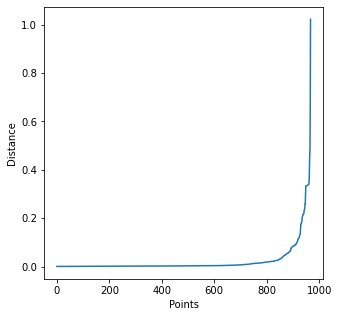

In [318]:
nearest_neighbors = NearestNeighbors(n_neighbors=11)
neighbors = nearest_neighbors.fit(train_scaled)
distances, indices = neighbors.kneighbors(train_scaled)

distances = np.sort(distances[:,10], axis=0)
i = np.arange(len(distances))
knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
plt.plot(distances)
plt.xlabel("Points")
plt.ylabel("Distance")

0.0316250920633721


<Figure size 360x360 with 0 Axes>

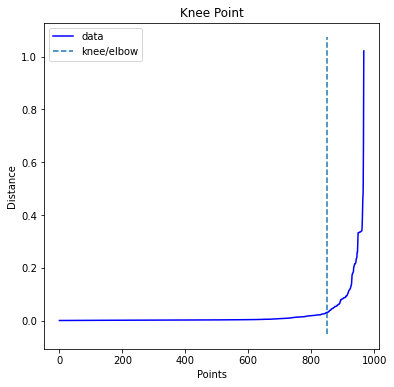

In [319]:
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
print(distances[knee.knee])

In [320]:
epsilon = distances[knee.knee]

In [321]:
dbsc = DBSCAN(eps=epsilon, min_samples=20).fit(train_scaled)

In [322]:
train_scaled

,is_webdev,is_data_sci,num_of_cohorts,average_visits_per_week
0,1.0,1.0,0.333333,0.221585
1,1.0,0.0,0.000000,0.490982
2,1.0,0.0,0.000000,0.125797
3,1.0,0.0,0.000000,0.352542
4,1.0,0.0,0.000000,0.333257
...,...,...,...,...
963,1.0,0.0,0.000000,0.073237
964,1.0,0.0,0.000000,0.218761
965,1.0,0.0,0.000000,0.139616
966,1.0,0.0,0.000000,0.323437


In [323]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(train_scaled.columns)
scaled_columns = ["Scaled_" + column for column in columns]

train_scaled.columns = scaled_columns

labels = dbsc.labels_
train_scaled['labels'] = labels

train = pd.merge(train, train_scaled, left_on='user_id', right_on=train_scaled.index)

In [324]:
train

,date,time,url,user_id,cohort_id,ip_address,has_visited_java,is_webdev,has_visited_classification,is_data_sci,num_of_cohorts,average_visits_per_week,Scaled_is_webdev,Scaled_is_data_sci,Scaled_num_of_cohorts,Scaled_average_visits_per_week,labels
0,2019-02-27,00:27:39,spring/fundamentals/views,303,27.0,72.190.225.242,547,1,0,0,1,57.0,1.0,0.0,0.0,0.090995,0
1,2019-01-28,11:01:06,mysql/tables,303,27.0,97.105.19.58,547,1,0,0,1,57.0,1.0,0.0,0.0,0.090995,0
2,2019-02-06,12:17:05,search/search_index.json,303,27.0,97.105.19.58,547,1,0,0,1,57.0,1.0,0.0,0.0,0.090995,0
3,2018-11-17,14:05:48,javascript-i/introduction/working-with-data-ty...,303,27.0,72.190.225.242,547,1,0,0,1,57.0,1.0,0.0,0.0,0.090995,0
4,2019-02-27,15:41:56,spring/extra-features,303,27.0,97.105.19.58,547,1,0,0,1,57.0,1.0,0.0,0.0,0.090995,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503659,2018-03-28,20:28:42,java-i/methods,161,12.0,108.87.103.243,9,1,0,0,1,11.0,1.0,0.0,0.0,0.011505,0
503660,2018-01-30,15:01:21,content/git,71,19.0,173.173.116.10,0,0,0,0,1,5.0,1.0,0.0,0.0,0.080896,0
503661,2018-01-30,15:01:40,content/git/initializing-a-repository.html,71,19.0,173.173.116.10,0,0,0,0,1,5.0,1.0,0.0,0.0,0.080896,0
503662,2018-02-03,12:04:45,html-css,81,18.0,107.207.7.120,0,0,0,0,1,3.0,0.0,0.0,0.0,0.001021,1


In [325]:
train.labels.value_counts()

 0    373329
-1     67230
 2     30132
 1     19011
 3     13962
Name: labels, dtype: int64

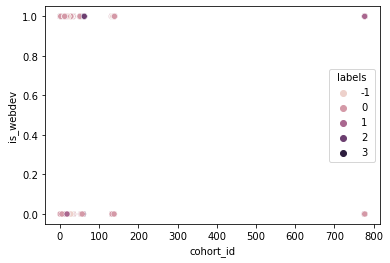

In [346]:
sns.scatterplot(train.cohort_id, train.is_webdev, hue=train.labels)
plt.show()

In [362]:
# Webdev students would be cohort_id < 100, is_webdev > 0
train[(train.cohort_id < 100) & (train.is_webdev == 1)].groupby('user_id').labels.mean().value_counts()

 0    495
-1     74
 2     24
 1     23
 3      6
Name: labels, dtype: int64

Most of these observations are labeled "0". This 

In [347]:
# Outliers of webdev students
outliers = train[(train.cohort_id > 100) | (train.is_webdev < 1)]
outliers

,date,time,url,user_id,cohort_id,ip_address,has_visited_java,is_webdev,has_visited_classification,is_data_sci,num_of_cohorts,average_visits_per_week,Scaled_is_webdev,Scaled_is_data_sci,Scaled_num_of_cohorts,Scaled_average_visits_per_week,labels
665,2020-10-20,15:55:57,clustering/project,696,59.0,67.11.85.236,0,0,242,1,1,38.151515,1.0,0.0,0.333333,0.105916,-1
666,2020-09-21,10:33:28,classification/logistic-regression,696,59.0,67.11.85.236,0,0,242,1,1,38.151515,1.0,0.0,0.333333,0.105916,-1
667,2020-09-10,14:16:44,classification/tidy-data,696,59.0,67.11.85.236,0,0,242,1,1,38.151515,1.0,0.0,0.333333,0.105916,-1
668,2020-08-31,14:53:36,stats/overview,696,59.0,67.11.85.236,0,0,242,1,1,38.151515,1.0,0.0,0.333333,0.105916,-1
669,2020-12-12,22:41:08,classification/explore,696,59.0,67.11.85.236,0,0,242,1,1,38.151515,1.0,0.0,0.333333,0.105916,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503651,2020-03-23,14:10:17,/,619,57.0,97.105.19.58,0,0,0,0,1,1.000000,1.0,0.0,0.000000,0.188763,0
503652,2020-05-06,19:06:32,/,649,5.0,70.125.150.41,0,0,0,0,1,1.000000,1.0,0.0,0.000000,0.166338,0
503660,2018-01-30,15:01:21,content/git,71,19.0,173.173.116.10,0,0,0,0,1,5.000000,1.0,0.0,0.000000,0.080896,0
503661,2018-01-30,15:01:40,content/git/initializing-a-repository.html,71,19.0,173.173.116.10,0,0,0,0,1,5.000000,1.0,0.0,0.000000,0.080896,0


In [363]:
# These are probably students with access to both curriculums
outliers[(outliers.cohort_id > 100) & (outliers.is_webdev > 0)].groupby('user_id').labels.mean().value_counts()

 0    132
-1     23
 1     11
 3      7
 2      2
Name: labels, dtype: int64

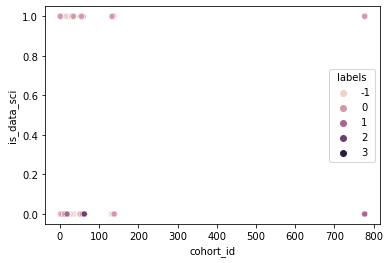

In [364]:
sns.scatterplot(train.cohort_id, train.is_data_sci, hue=train.labels)
plt.show()

In [368]:
# Data science students would be cohort_id > 100 and < 200, is_data_sci == 1
train[(train.cohort_id > 100) & (train.cohort_id < 200) & (train.is_data_sci == 1)].groupby('user_id').labels\
.mean().value_counts()

 0    19
-1     7
 3     4
 2     3
 1     2
Name: labels, dtype: int64

In [369]:
data_sci_outliers = train[(train.cohort_id < 100) | (train.cohort_id > 200) | (train.is_data_sci < 1)]
data_sci_outliers.groupby('user_id').labels.mean().value_counts()

 0    690
-1    124
 2     47
 1     43
 3     17
Name: labels, dtype: int64

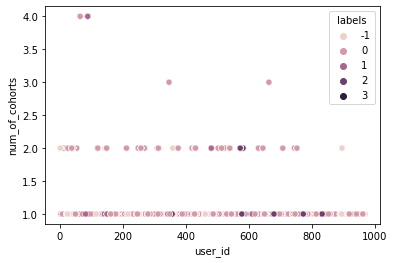

In [365]:
sns.scatterplot(train.user_id, train.num_of_cohorts, hue=train.labels)
plt.show()

In [370]:
# Most students should only have 1 cohort
train[train.num_of_cohorts == 1].groupby('user_id').labels.mean().value_counts()

 0    676
-1    124
 2     48
 1     43
 3     21
Name: labels, dtype: int64

In [371]:
# instructors, teaching assistants, students that do both programs, or dnf can have 2 cohorts
train[train.num_of_cohorts == 2].groupby('user_id').labels.mean().value_counts()

 0    30
-1     6
 2     2
 1     1
Name: labels, dtype: int64

In [372]:
# students that become TAs that become instructors should be the only case to have 3 cohorts
train[train.num_of_cohorts == 3].groupby('user_id').labels.mean().value_counts()

0    2
Name: labels, dtype: int64

This result is unhelpful... 

In [373]:
# Very odd case
train[train.num_of_cohorts == 4].groupby('user_id').labels.mean().value_counts()

0    1
1    1
Name: labels, dtype: int64

I was hoping these would be labeled -1

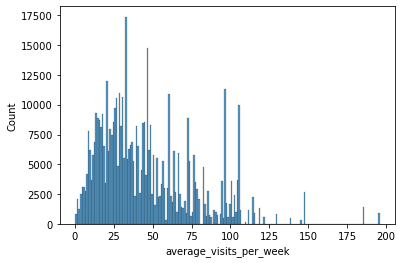

count    503664.000000
mean         45.512075
std          30.899233
min           0.157143
25%          22.350000
50%          37.176471
75%          62.111111
max         196.000000
Name: average_visits_per_week, dtype: float64


In [330]:
sns.histplot(train.average_visits_per_week)
plt.show()

print(train.average_visits_per_week.describe())

In [342]:
upper, lower = utils.generate_outlier_bounds_iqr(train, 'average_visits_per_week', multiplier=1.5)

In [343]:
(lower, upper)

(-37.291666666666664, 121.75277777777778)

In [345]:
train[train.average_visits_per_week >= 122].describe()

,user_id,cohort_id,has_visited_java,is_webdev,has_visited_classification,is_data_sci,num_of_cohorts,average_visits_per_week,Scaled_is_webdev,Scaled_is_data_sci,Scaled_num_of_cohorts,Scaled_average_visits_per_week,labels
count,6628.000000,6628.000000,6628.000000,6628.000000,6628.000000,6628.000000,6628.0,6628.000000,6628.0,6628.0,6628.0,6628.000000,6628.000000
mean,553.191460,60.216657,967.328153,0.880507,32.741098,0.119493,1.0,159.184969,1.0,0.0,0.0,0.236128,-0.253319
std,243.778205,43.993999,515.024751,0.324392,88.883482,0.324392,0.0,23.179081,0.0,0.0,0.0,0.222570,0.434945
min,23.000000,22.000000,0.000000,0.000000,0.000000,0.000000,1.0,129.090909,1.0,0.0,0.0,0.043451,-1.000000
25%,418.000000,32.000000,588.000000,1.000000,0.000000,0.000000,1.0,147.300000,1.0,0.0,0.0,0.057102,-1.000000
50%,449.000000,33.000000,1069.000000,1.000000,0.000000,0.000000,1.0,147.300000,1.0,0.0,0.0,0.182718,0.000000
75%,823.000000,134.000000,1515.000000,1.000000,0.000000,0.000000,1.0,185.571429,1.0,0.0,0.0,0.606572,0.000000
max,951.000000,134.000000,1515.000000,1.000000,274.000000,1.000000,1.0,196.000000,1.0,0.0,0.0,0.606572,0.000000


These outliers are webdev students (is_webdev mean = .88 and is_data_sci mean = .12), they were only students (num_of_cohorts mean, median, and max == 1), and they graduated (cohort_id max is 134 which means there were no 777 (dnf) observations).

## Other possible features
* 97.105.19.58, 97.105.19.61 were the two IP addresses where the curriculum was most accessed from, so we can assume these were the Codeup classrooms.
* Can create feature `attended_in_person` if user_id accessed curriculumn from this IP address
* Can create features `is_instructor` and `is_teaching_assistant` from user_id = 28 and user_id = 1.